# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import time
import copy
import os


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']

calls = {}
pairs = {}
lives = {}

## MIT

A different approach. I will create a dictionary with the calls data fro all three cohorts. This time, I will keep all egos, because I will make some constraints to the data in order to make pairs of ego-alter comparable, even if they appeared at different points in time. 

In [2]:
%time calls['mit'] = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
calls['mit'].head()

CPU times: user 380 ms, sys: 53.4 ms, total: 433 ms
Wall time: 432 ms


ego                                     alter                time  \
0  fa10-01-19  10153fa58c24d1a2eb54b3c6ac39482acb61131c 2010-12-31 16:44:24   
1  fa10-01-22  101b96d65031e2792acd950125d90cf9ff30b5ac 2011-05-23 20:59:05   
2  fa10-01-12  1023b616632f3ba048b2f1d1374788bfa0444a8d 2011-01-22 14:01:07   
3  fa10-01-01  102c517fc9ecf84975448470893c3799f5588c8a 2011-05-27 17:52:56   
4  fa10-01-07  102cd812edb5689302bcc57df8330cff44727bd1 2011-04-04 10:02:50   

   uclock  aclock  
0     307       0  
1     450       0  
2     328       0  
3     454       0  
4     400       0

In [3]:
%time pairs['mit'] = pc.pairs(calls['mit'])
%time lives['mit'] = pc.lives_dictionary(calls['mit'])

CPU times: user 34.4 ms, sys: 1.43 ms, total: 35.8 ms
Wall time: 34.4 ms
CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 170 ms


## UK

I need to divide the UK dataset in two cohorts: `uk1` contains all alters appeared in the first six months of data; and `uk2` all alters appearing after six months

In [4]:
tmp1 = pc.allcalls("../ukdata/collected_dunbar_calls_v3_e26OK_sorted.csv", (3, 'call'), 1, 2, [6,7], '%d/%m/%y %H:%M', header=False, min_activity=1)
tmp1.head()

ego           alter                time  uclock  aclock
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0

In [5]:
# Temporary data, since I will create two cohorts out of these
tmp2 = pc.pairs(tmp1)
tmp3 = pc.lives_dictionary(tmp1)

In [6]:
rmalter = {}
for ego in tmp3.keys():
    rmalter[ego] = []
    for alter in tmp3[ego].keys():
        if tmp3[ego][alter]['t0'] < 180:
            rmalter[ego].append(alter)
            
for i in tmp1.index:
    ego = tmp1.at[i, 'ego']
    alter = tmp1.at[i, 'alter']
    if alter in rmalter[ego]:
        tmp1.at[i, 'rm'] = 1
    else:
        tmp1.at[i, 'rm'] = 0

calls['uk1'] = tmp1.loc[tmp1['rm'] == 1]
calls['uk1'].drop(columns=['rm'], inplace=True)
calls['uk1'].reset_index(drop=True, inplace=True)

new = tmp1.loc[tmp1['rm'] == 0]
new = new.loc[new['uclock'] >= 180]
new['uclock'] -= 180
new.to_csv("tmp2.csv")
calls['uk2'] = pc.allcalls("tmp2.csv", (), 'ego', 'alter', ['time'], '%Y-%m-%d %H:%M:%S')
calls['uk2'].reset_index(drop=True, inplace=True)
os.system("rm tmp2.csv")

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0

In [7]:
len(calls['uk1']) + len(calls['uk2']) == len(tmp1)

True

In [8]:
for c in ['uk1', 'uk2']:
    pairs[c] = pc.pairs(calls[c])
    lives[c] = pc.lives_dictionary(calls[c])

# Limit data

In order to make all pairs of ego-alters (in all three cohorts comparable, I will limit the amount of phone calls to be analized, using the following criteria:

1. Only consider phone calls made by egos 30 days or later than their first appeareance.
2. For each alter, its maximum value of $a$ will be 200 days. This makes $\max_{\ell} = 200$.
3. Remove all alters whose first appeareance was **after** $T - \max{a}$. This is to guarantee that every alter could potentially reach $\max{a}$.

## Remove first 30 days of activity for each ego

In [9]:
calls.keys()

dict_keys(['mit', 'uk1', 'uk2'])

In [10]:
for c in calls.keys():
    uno = calls[c].groupby('ego')[['uclock']].min()
    dos = pd.DataFrame()
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + 30
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(calls[c])
    calls[c] = dos
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 19098 calls
uk1 lost 5733 calls
uk2 lost 1684 calls


## Limit $\max{a}$ to 200

In [11]:
for c in calls.keys():
    old = len(calls[c])
    calls[c] = calls[c].loc[calls[c]['aclock'] <= 200]
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 24426 calls
uk1 lost 37748 calls
uk2 lost 3229 calls


## Remove all alters with $t(0) > T - \max{a}$

In [12]:
for c in calls.keys():
    uno = pd.DataFrame()
    T = max(calls[c]['uclock'])
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (T - 200):
                df2.loc[:, 'aclock'] = df2['uclock'] - mint
                uno = uno.append(df2).reset_index(drop=True)
    old = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    calls[c] = uno
    new = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    print(f'{c} lost {old - new} pairs of ego-alter')

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


mit lost 7649 pairs of ego-alter
uk1 lost 38 pairs of ego-alter
uk2 lost 1905 pairs of ego-alter


In [13]:
maxell = 0
for c in lives.keys():
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            if ell > maxell:
                maxell = ell
    print(f'{c} has max ell {maxell}')

mit has max ell 458
uk1 has max ell 534
uk2 has max ell 534


In [14]:
for c in calls.keys():
    pairs[c] = pc.pairs(calls[c])
    lives[c] = pc.lives_dictionary(calls[c])

## This is a required fix

For some reason, the above calls dataframes do not have the correct $a$ variable for some of the calls. To fix it, the code below is required.

In [15]:
#timer0 = time.time()
#for c in calls.keys():
#    df = calls[c]
#    newdf = pd.DataFrame()
#    for ego in df['ego'].unique():
#        df2 = df.loc[df['ego'] == ego]
#        for alter in df2['alter'].unique():
#            df3 = df2.loc[df2['alter'] == alter]
#            t0 = lives[c][ego][alter]['t0']
#            df3['aclock'] = df3['uclock'] - t0
#            newdf = newdf.append(df3).reset_index(drop=True)
#    calls[c] = newdf
#print(f'Took {time.time() - timer0}')

In [16]:
maxell = 0
for c in lives.keys():
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            if ell > maxell:
                maxell = ell
    print(f'{c} has max ell {maxell}')

mit has max ell 200
uk1 has max ell 200
uk2 has max ell 200


# Histogram of $\ell$

Even considering that the lifetime of every alter is limited to $0 \leq \ell \leq 200$; to deal with the heterogeneous values I could find, I will use bins of 10 days to create $0 \leq \lambda \leq 20$

In [17]:
timer0 = time.time()
Hlamb = {}
for c in lives.keys():
    Hlamb[c] = {}
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            lamb = lives[c][ego][alter]['ell'] // 10
            Hlamb[c][lamb] = Hlamb[c].get(lamb, 0) + 1
    Hlamb[c] = pd.DataFrame.from_dict(Hlamb[c], orient='index')
    Hlamb[c].sort_index(inplace=True)
print(f'This block took {time.time() - timer0}')

This block took 0.004239082336425781


In [18]:
plt.xlabel(r'$\lambda \; ; \Delta \ell = 10$')
plt.ylabel(r'$H(\lambda)$')
plt.yscale("log")
plt.xticks(range(21))
m = 0
for c in Hlamb.keys():
    plt.plot(Hlamb[c].index, Hlamb[c][0], marker=markers[m], linestyle="--", markersize=15, label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
    m += 1
plt.legend()

# Histogram of $a$

Similar to $\ell$, I will calculate the histogram of $a$ by taking bins of size 10. Thus, $0 \leq \alpha \leq 20$

In [19]:
timer0 = time.time()
Fa = {}
for c in calls.keys():
    Fa[c] = {}
    df = calls[c]
    df['alpha'] = df['aclock'] // 10
    df2 = df.groupby(['alpha'])[['aclock']].count()
    for i in df2.index:
        Fa[c][i] = df2.at[i, 'aclock']
    Fa[c] = pd.DataFrame.from_dict(Fa[c], orient='index')
    Fa[c].sort_index(inplace=True)
print(f'This block took {time.time() - timer0}')

This block took 0.009235858917236328


In [20]:
plt.xlabel(r'$\alpha \; ; \Delta a = 10$')
plt.ylabel(r'$F(\alpha)$')
plt.yscale("log")
plt.xticks(range(21))
m = 0
for c in Fa.keys():
    plt.plot(Fa[c].index, Fa[c][0], marker=markers[m], linestyle="--", markersize=15, label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
    m += 1
plt.legend()

# $\langle b \rangle$ as a function of $\lambda$

In [21]:
dff = {}
for c in calls.keys():
    %time dff[c] = pc.get_f(calls[c], 'all', 70, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 9.11 s, sys: 0 ns, total: 9.11 s
Wall time: 9.12 s
CPU times: user 3.67 s, sys: 0 ns, total: 3.67 s
Wall time: 3.67 s
CPU times: user 2.4 s, sys: 0 ns, total: 2.4 s
Wall time: 2.4 s


In [22]:
bplot = {}
for c in dff.keys():
    %time b = pc.get_b(dff[c], 'lambda')
    %time bplot[c] = pc.plot_g(b, 'lambda')

CPU times: user 2.28 s, sys: 23 ms, total: 2.31 s
Wall time: 2.31 s
CPU times: user 47 ms, sys: 14 µs, total: 47 ms
Wall time: 46.2 ms
CPU times: user 835 ms, sys: 10.1 ms, total: 845 ms
Wall time: 844 ms
CPU times: user 25.8 ms, sys: 0 ns, total: 25.8 ms
Wall time: 25.6 ms
CPU times: user 550 ms, sys: 3.29 ms, total: 553 ms
Wall time: 553 ms
CPU times: user 24.2 ms, sys: 41 µs, total: 24.3 ms
Wall time: 23.6 ms


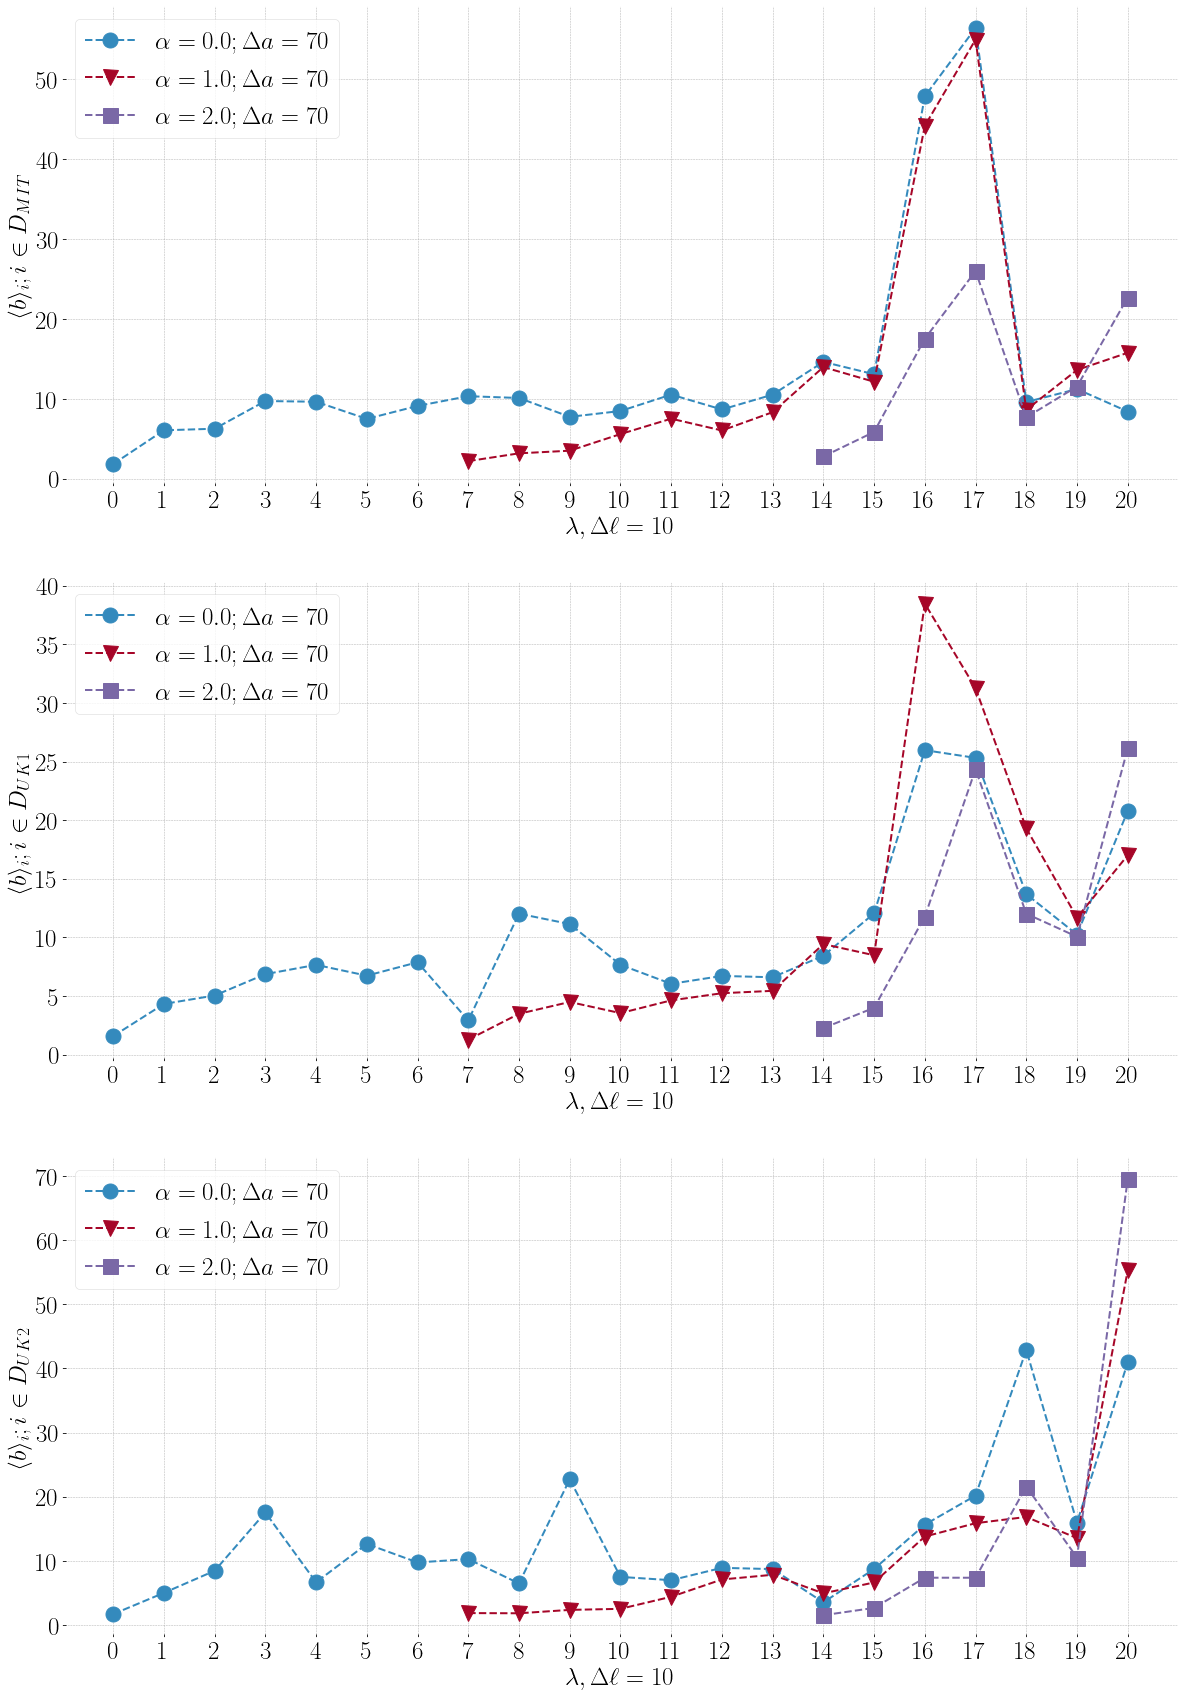

In [23]:
plt.figure(figsize=(20, 30))
p = 1
for c in bplot.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda, \Delta \ell = 10$")
    plt.ylabel(fr"$\langle b \rangle_i; i \in {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.xticks(range(21))
    m = 0
    for alpha in bplot[c].keys():
        plt.plot(bplot[c][alpha].index, bplot[c][alpha]['lambda'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\alpha = {alpha}; \Delta a = 70$')
        m += 1
    p += 1
    plt.legend()

## $\langle b \rangle$ as a function of $\alpha$

In [24]:
dff2 = {}
for c in calls.keys():
    %time dff2[c] = pc.get_f(calls[c], 'all', 10, 70)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 9.17 s, sys: 23 ms, total: 9.2 s
Wall time: 9.2 s
CPU times: user 3.63 s, sys: 0 ns, total: 3.63 s
Wall time: 3.63 s
CPU times: user 2.4 s, sys: 0 ns, total: 2.4 s
Wall time: 2.4 s


In [25]:
bplot2 = {}
for c in dff2.keys():
    %time b = pc.get_b(dff2[c], 'alpha')
    %time bplot2[c] = pc.plot_g(b, 'alpha')

CPU times: user 2.68 s, sys: 13.2 ms, total: 2.7 s
Wall time: 2.69 s
CPU times: user 55.8 ms, sys: 0 ns, total: 55.8 ms
Wall time: 55.2 ms
CPU times: user 1.03 s, sys: 6.72 ms, total: 1.04 s
Wall time: 1.03 s
CPU times: user 27.8 ms, sys: 37 µs, total: 27.9 ms
Wall time: 26.8 ms
CPU times: user 679 ms, sys: 6.61 ms, total: 685 ms
Wall time: 685 ms
CPU times: user 25.5 ms, sys: 71 µs, total: 25.6 ms
Wall time: 25.5 ms


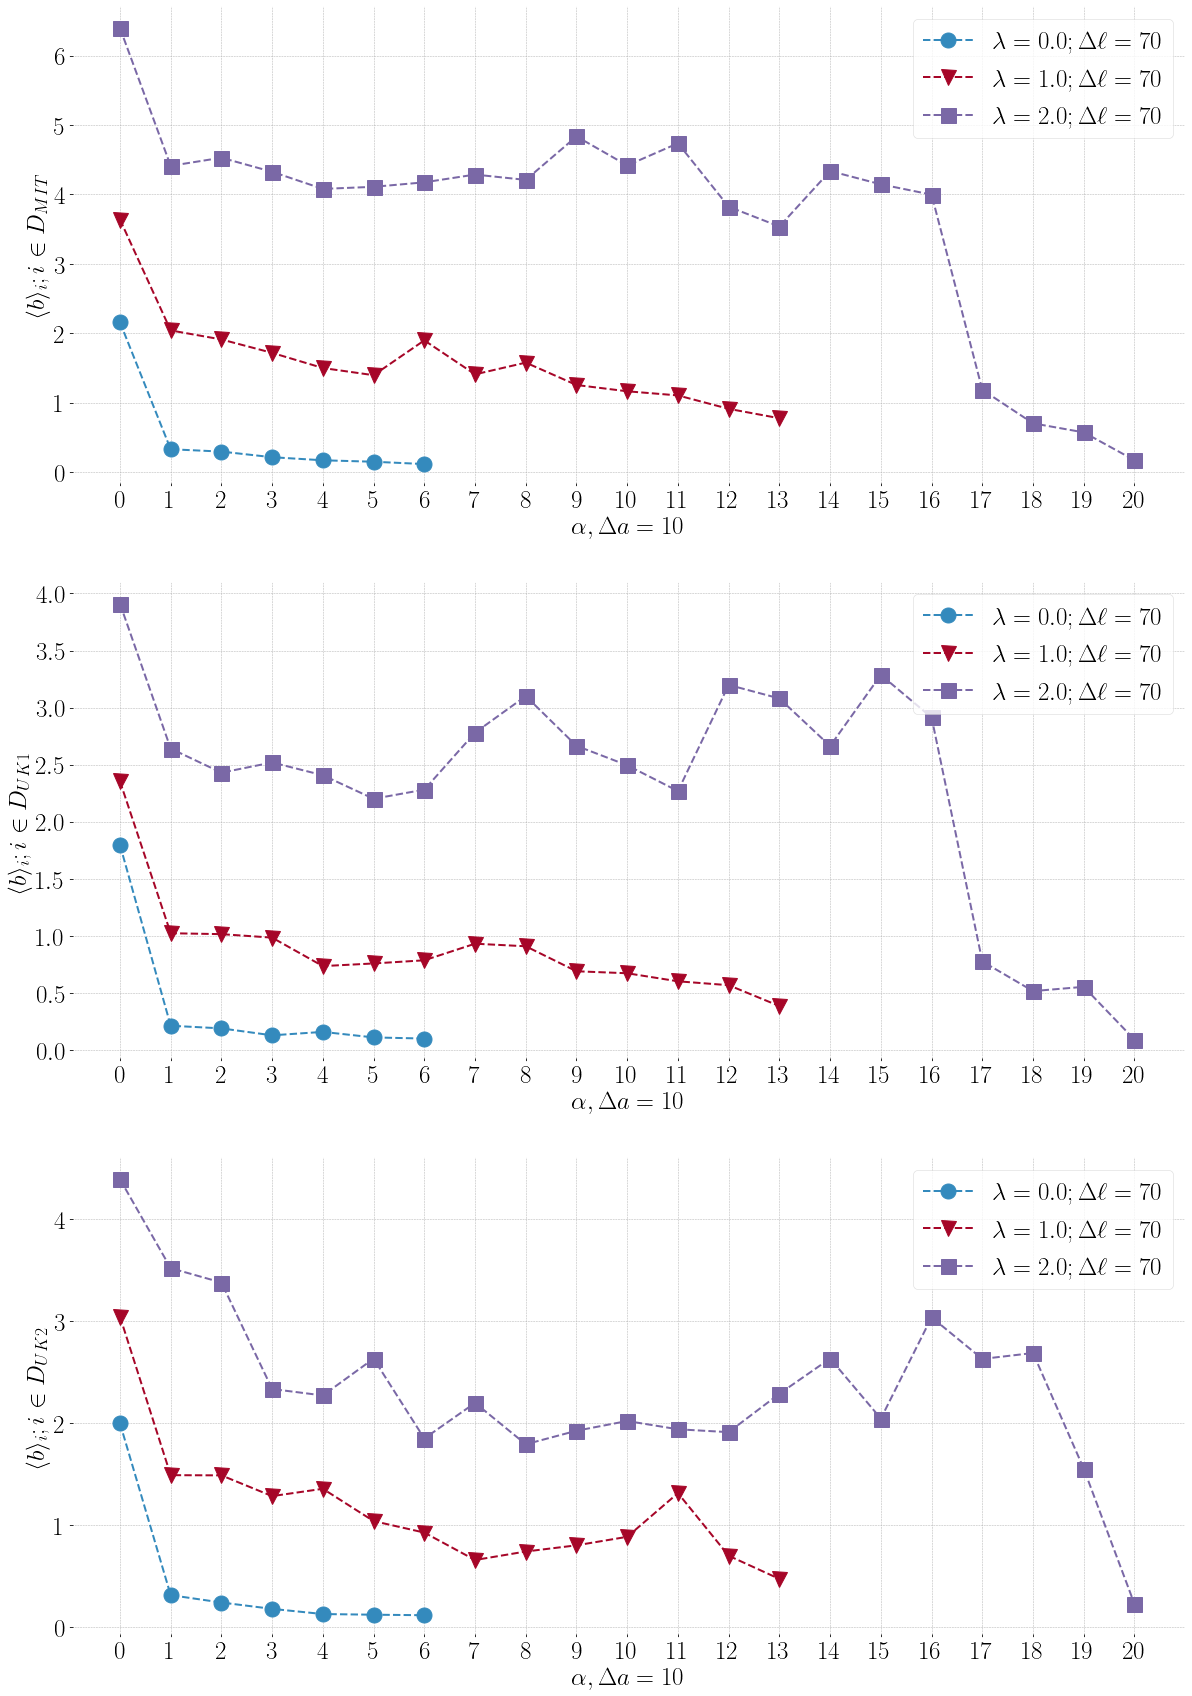

In [26]:
plt.figure(figsize=(20, 30))
p = 1
for c in bplot2.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\alpha, \Delta a = 10$")
    plt.ylabel(fr"$\langle b \rangle_i; i \in {['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.xticks(range(21))
    m = 0
    for lamb in bplot2[c].keys():
        plt.plot(bplot2[c][lamb].index, bplot2[c][lamb]['alpha'], marker=markers[m], markersize=15, linestyle="--", label=fr'$\lambda = {lamb}; \Delta \ell = 70$')
        m += 1
    p += 1
    plt.legend()

# Lifetime separated by activity

In [27]:
fdist = {}
perc = {}
for c in dff.keys():
    allf = []
    for ego in dff[c].keys():
        for alter in dff[c][ego].keys():
            df = dff[c][ego][alter].loc[dff[c][ego][alter]['alpha'] == 1]
            for i in df['f']:
                allf.append(i)
    perc[c] = [np.percentile(allf, q) for q in (33, 66, 100)]
    fdist[c] = pc.f_histell(dff[c], 1, perc[c])

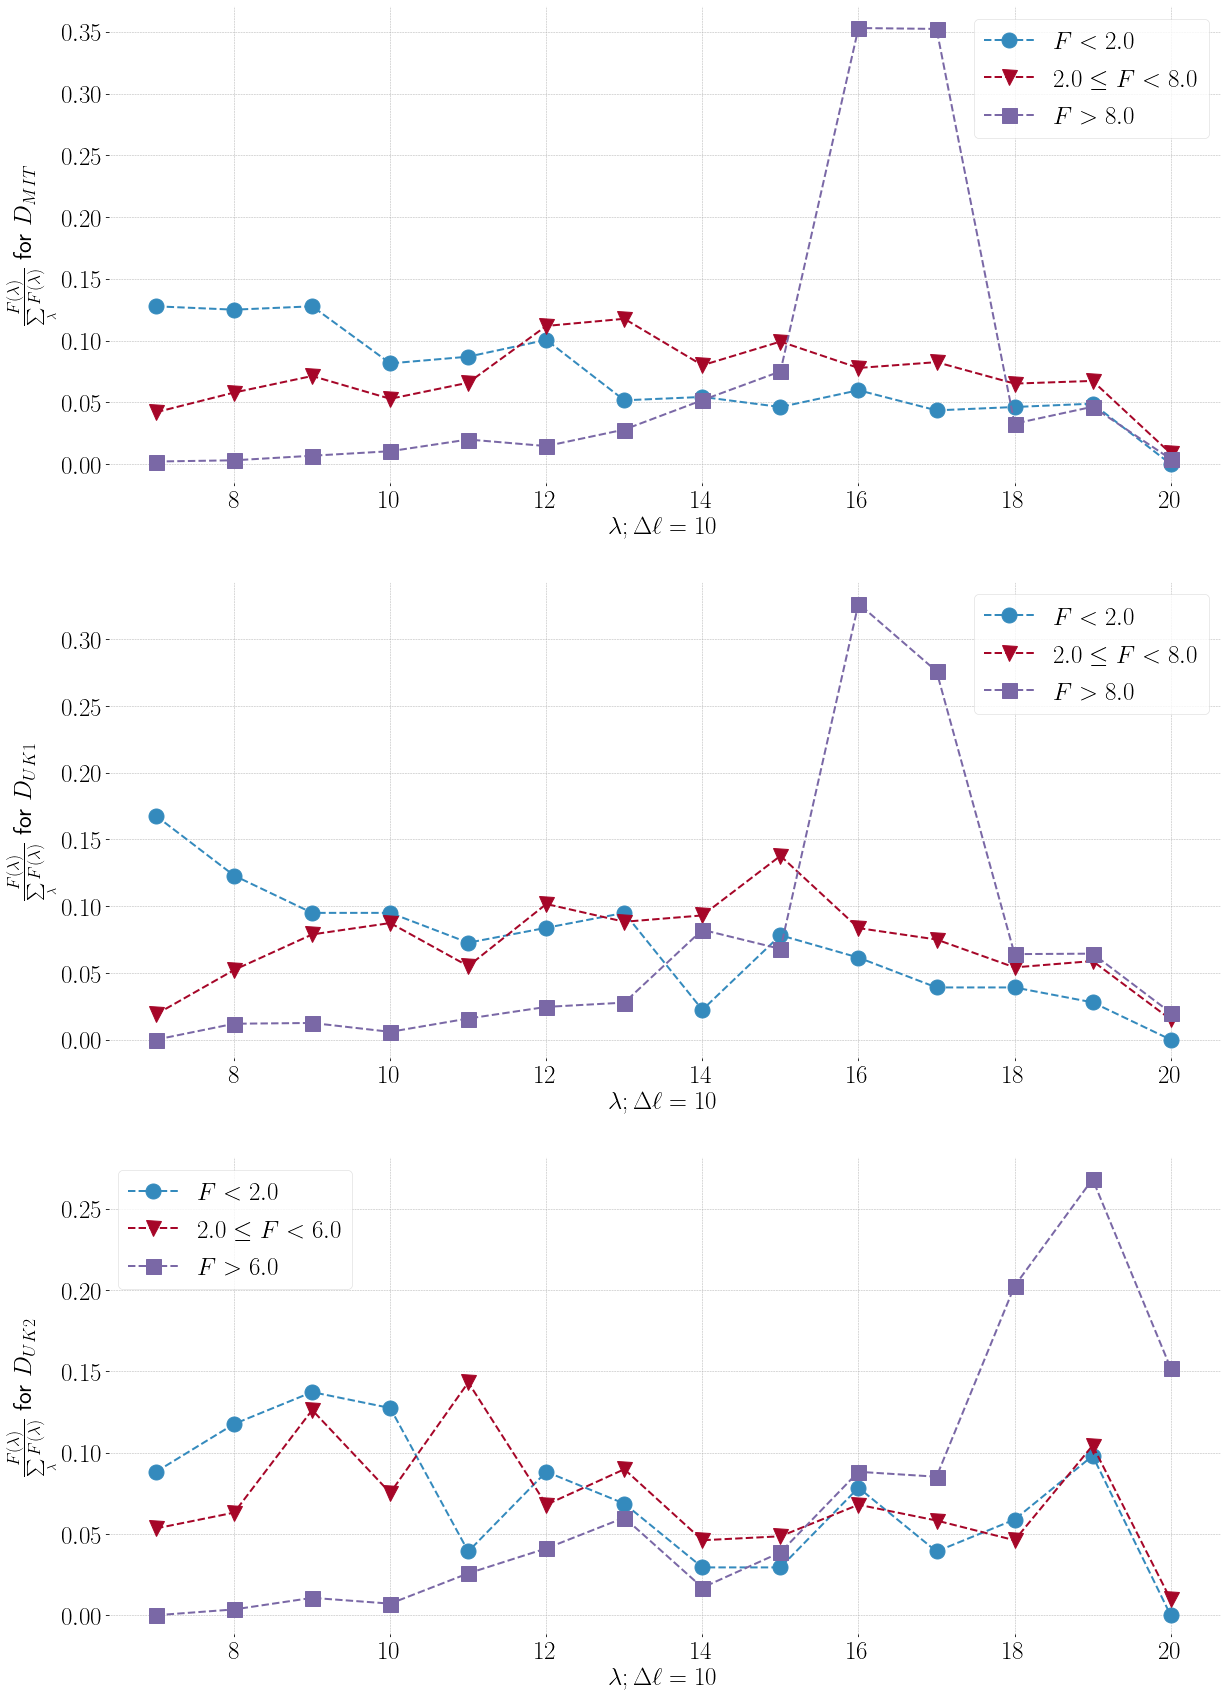

In [28]:
plt.figure(figsize=(20, 30))
p = 1
for c in fdist.keys():
    plt.subplot(3, 1, p)
    legends = [fr"$F < {perc[c][0]}$", fr"${perc[c][0]} \leq F < {perc[c][1]}$", fr"$F > {perc[c][1]}$", r"All $F$"]
    plt.xlabel(r"$\lambda; \Delta \ell = 10$")
    plt.ylabel(r"$\frac{F(\lambda)}{\sum\limits_{\lambda} F(\lambda)}$ " + fr" for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    for i in range(3):
        plt.plot(fdist[c][i].index, fdist[c][i][0] / sum(fdist[c][i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
    plt.legend()
    p+=1

# $\phi$ as bins of activity

In [29]:
phiD = {}
for delta in (3, 5, 7):
    phiD[delta] = {}
    for c in dff.keys():
        phiD[delta][c] = pc.f_histell(dff[c], 1, [], binned=True, deltaF=delta)

In [30]:
plt.figure(figsize=(36, 24))
p = 1
for delta in phiD.keys():
    for c in phiD[delta].keys():
        plt.subplot(3, 3, p) 
        plt.xlabel(r"$\lambda; \Delta \ell = 10$")
        plt.ylabel(r"$\frac{F(\lambda)}{\sum\limits_{\lambda} F(\lambda)}$ " + fr" for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][(p - 1) % 3]}$")
        plt.xticks(range(21))
        phis = sorted(phiD[delta][c].keys())[:7]
        #phis += sorted(phi4[c].keys())[-20:-17]
        #print(sorted(phi4[c].keys()))
        m = 0
        for phi in phis:
            plt.plot(phiD[delta][c][phi].index, phiD[delta][c][phi][0] / sum(phiD[delta][c][phi][0]), marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \Delta F = {delta}$")
            m += 1
        plt.legend()
        p += 1

# Probability of alter reaching $\lambda_c$

In [31]:
phi3 = {}
for c in dff.keys():
    phi3[c] = pc.f_histell(dff[c], 1, [], binned=True, deltaF=3)

result = {}
for c in phi3.keys():
    result[c] = {}
    for lambc in [15, 16, 17, 18]:
        result[c][lambc] = {}
        for phi in phi3[c].keys():
            df = phi3[c][phi]
            df['p'] = df[0] / sum(df[0])
            df2 = df.loc[df.index >= lambc]
            if len(df2) > 0:
                result[c][lambc][phi] = sum(df2['p'])
        result[c][lambc] = pd.DataFrame.from_dict(result[c][lambc], orient='index')
        result[c][lambc].sort_index(inplace=True)

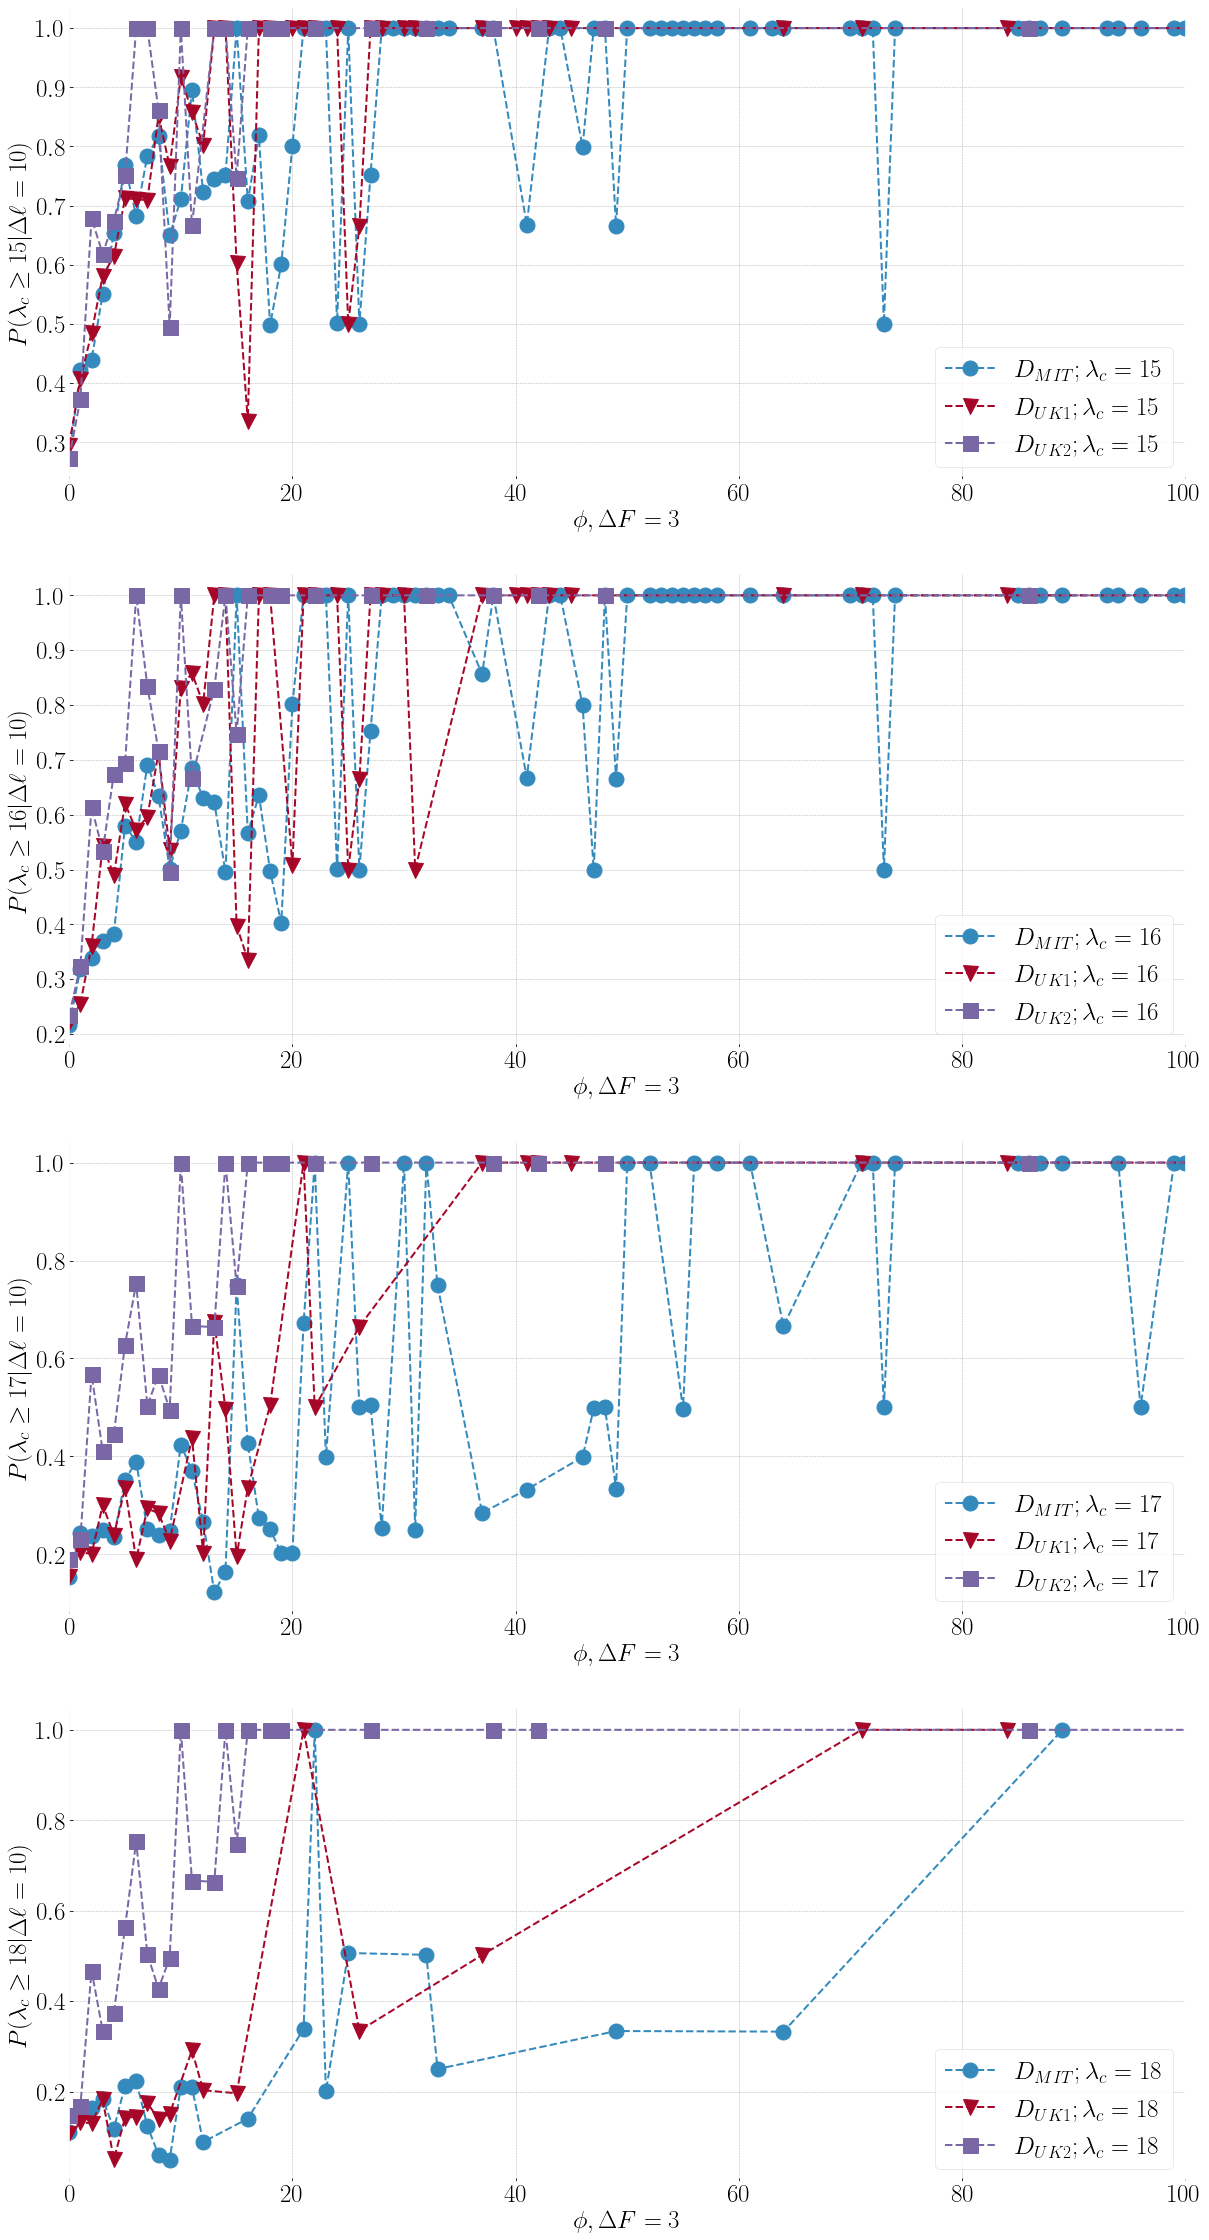

In [32]:
plt.figure(figsize=(20, 40))
p = 1
for lambc in [15, 16, 17, 18]:
    plt.subplot(4, 1, p)
    plt.xlabel(r"$\phi, \Delta F = 3$")
    plt.ylabel(fr"$P(\lambda_c \geq {lambc} | \Delta \ell = 10)$")
    plt.xlim(0, 100)
    m = 0
    for c in result.keys():
        plt.plot(result[c][lambc].index, result[c][lambc][0], marker=markers[m], markersize=15, linestyle="--", label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}; \lambda_c = {lambc}$")
        m += 1
    plt.legend()
    p += 1

## Increase $\Delta F$

In [33]:
fdist2 = {}
for c in dff.keys():
    %time fdist2[c] = pc.f_histell(dff[c], 1, [5, 10, 10000])

CPU times: user 3.62 s, sys: 3.89 ms, total: 3.62 s
Wall time: 3.59 s
CPU times: user 1.52 s, sys: 36 µs, total: 1.52 s
Wall time: 1.52 s
CPU times: user 870 ms, sys: 35 µs, total: 870 ms
Wall time: 869 ms


In [34]:
lcdist = {}
for phi in range(3):
    lcdist[phi] = {}
    for c in fdist2.keys():
        lcdist[phi][c] = {}
        df = fdist2[c][phi]
        df['p'] = df[0] / sum(df[0])
        for lc in range(5, 20):
            df2 = df.loc[df.index >= lc]
            lcdist[phi][c][lc] = sum(df2['p'])
        lcdist[phi][c] = pd.DataFrame.from_dict(lcdist[phi][c], orient='index')
        lcdist[phi][c].sort_index(inplace=True)

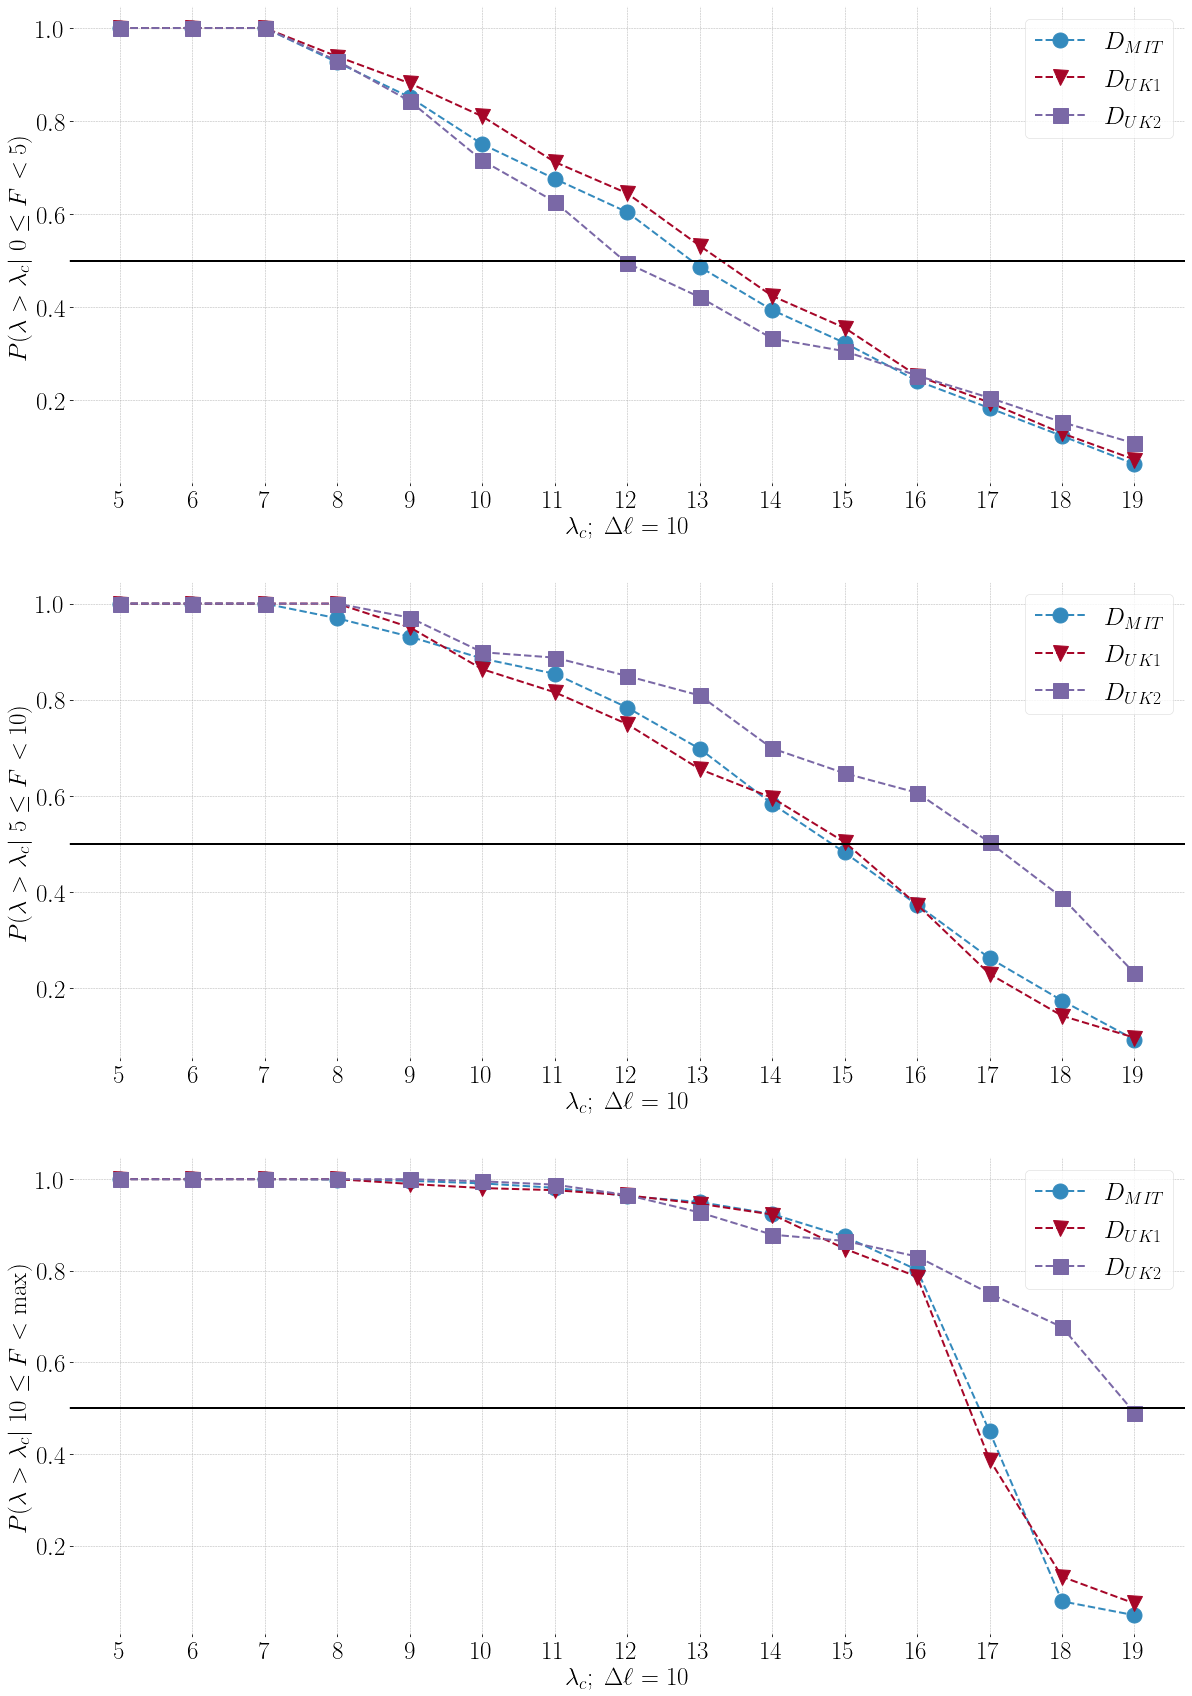

In [35]:
plt.figure(figsize=(20, 30))
p = 1
fs = [0, 5, 10, '\max']
for phi in lcdist.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda_{c}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c | \; {fs[phi]} \leq F < {fs[phi + 1]})$")
    plt.xticks(range(20))
    m = 0
    for c in lcdist[phi].keys():
        plt.plot(lcdist[phi][c].index, lcdist[phi][c][0], marker=markers[m], markersize=15, linestyle="--", label=fr"${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][m]}$")
        m += 1
    plt.axhline(0.5, color="black")
    plt.legend()
    p += 1

In [36]:
maxf = {}
for c in dff.keys():
    maxf[c] = 0
    for ego in dff[c].keys():
        for alter in dff[c][ego].keys():
            df = dff[c][ego][alter]
            localmax = max(df['f'])
            if localmax > maxf[c]:
                maxf[c] = localmax

maxf

{'mit': 536, 'uk1': 916, 'uk2': 617}

I need to choose a point (e.g. 0.5) in the vertical axis, and see what happens with the horizontal axis. The idea is that for each cohort, I will try to make that point in the horizontal axis coincide. Then, using some scaling factor, make the curves coincide. It is important that this needs to be done on a cohort basis, to unbderstand what I'm getting as results.

1. The first thing I will try to scale the three series (just for MIT, in order to test) will be dividing the values in the horizontal axis by some value $(\min{F})^{0.08}$

In [37]:
plt.xticks(range(20))
plt.xlabel(r"$\frac{\lambda_{c}}{(\min{F}^{0.08})}; \; \Delta \ell = 10$")
plt.ylabel(fr"$P(\lambda > \lambda_c)$")
for phi in lcdist.keys():
    plt.plot(lcdist[phi]['mit'].index / [1, 5**(0.08), 10**(0.08)][phi], lcdist[phi]['mit'][0] / 1, marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
plt.axhline(0.5, color="black")
plt.legend()

And now test the same number for all three cohorts

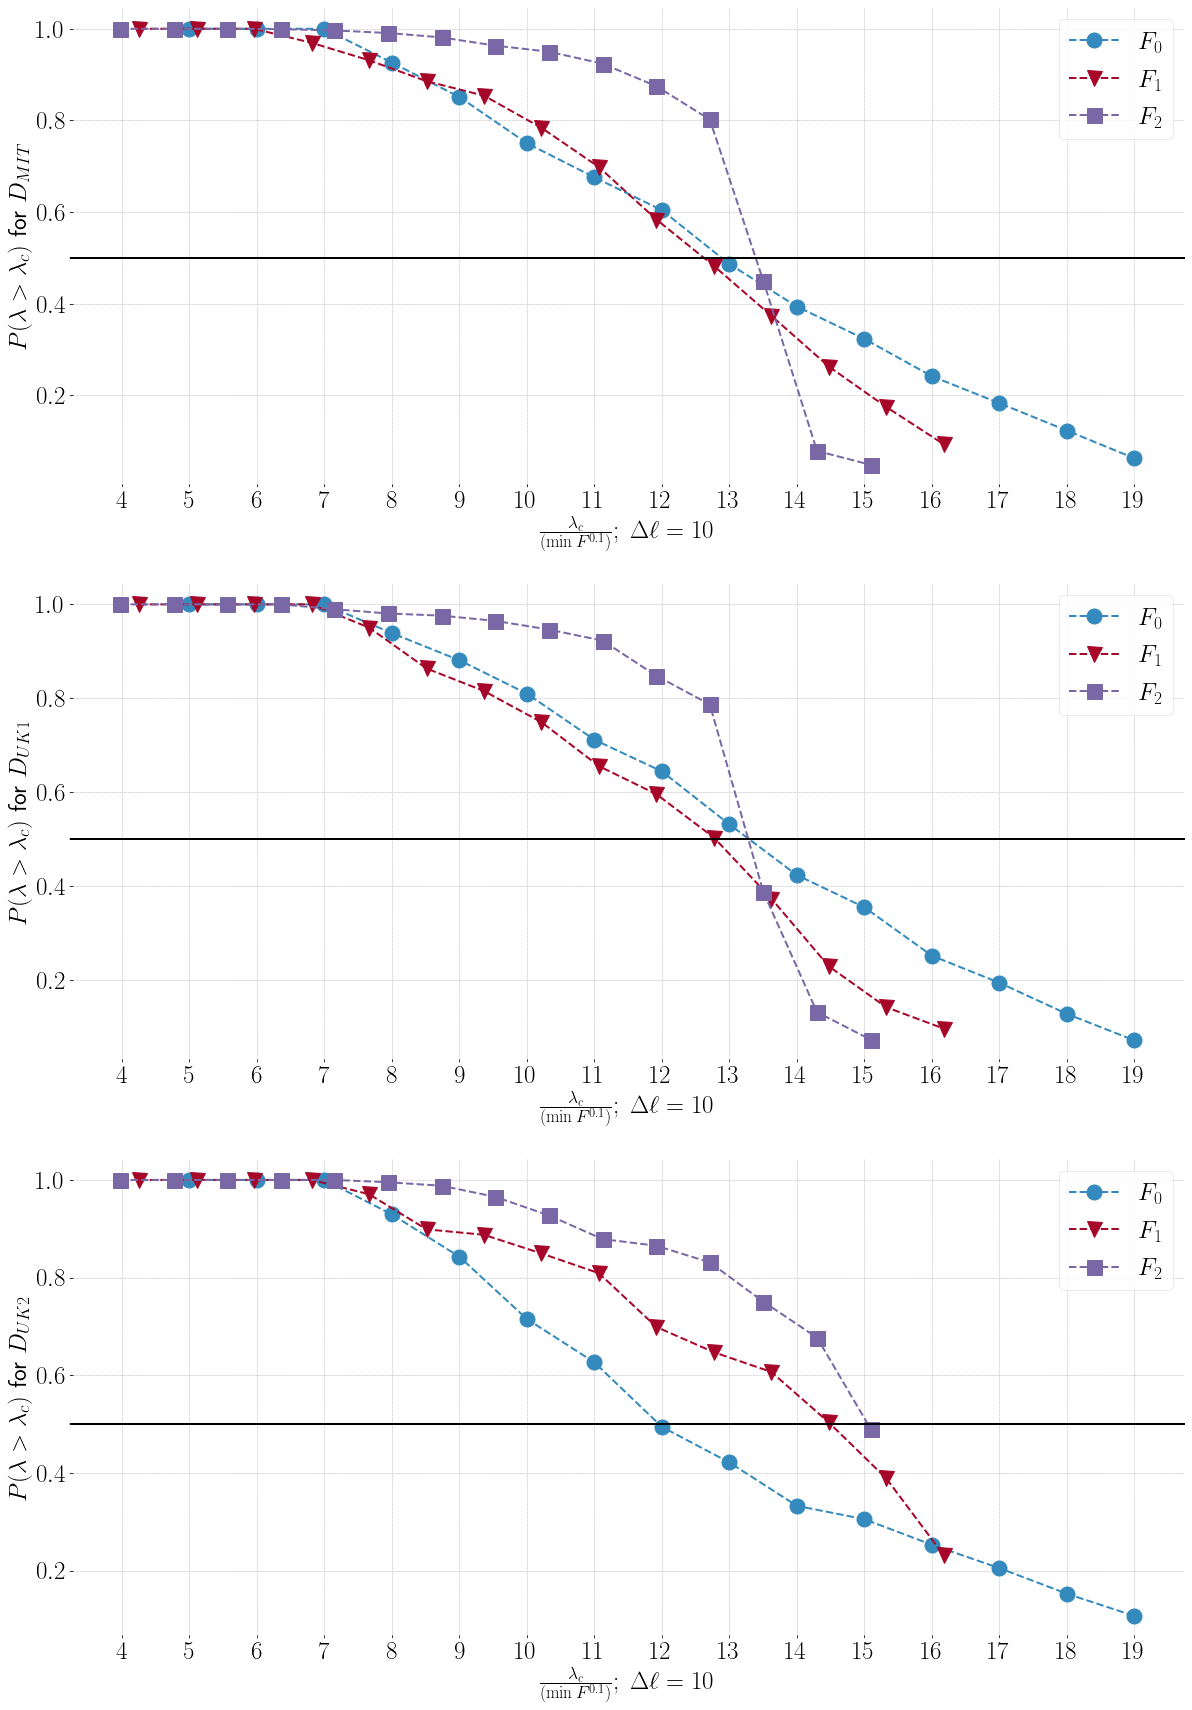

In [38]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdist[0].keys():
    plt.subplot(3, 1, p)
    plt.xticks(range(20))
    plt.xlabel(r"$\frac{\lambda_{c}}{(\min{F}^{0.1})}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    for phi in lcdist.keys():
        plt.plot(lcdist[phi][c].index / [1, 5**(0.1), 10**(0.1)][phi], lcdist[phi][c][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
    plt.axhline(0.5, color="black")
    plt.legend()
    p += 1

Since $D_{UK2}$ does not scale well using $(\min{F})^{0.1}$, I will use $(\min{F})^{0.2}$ instead.

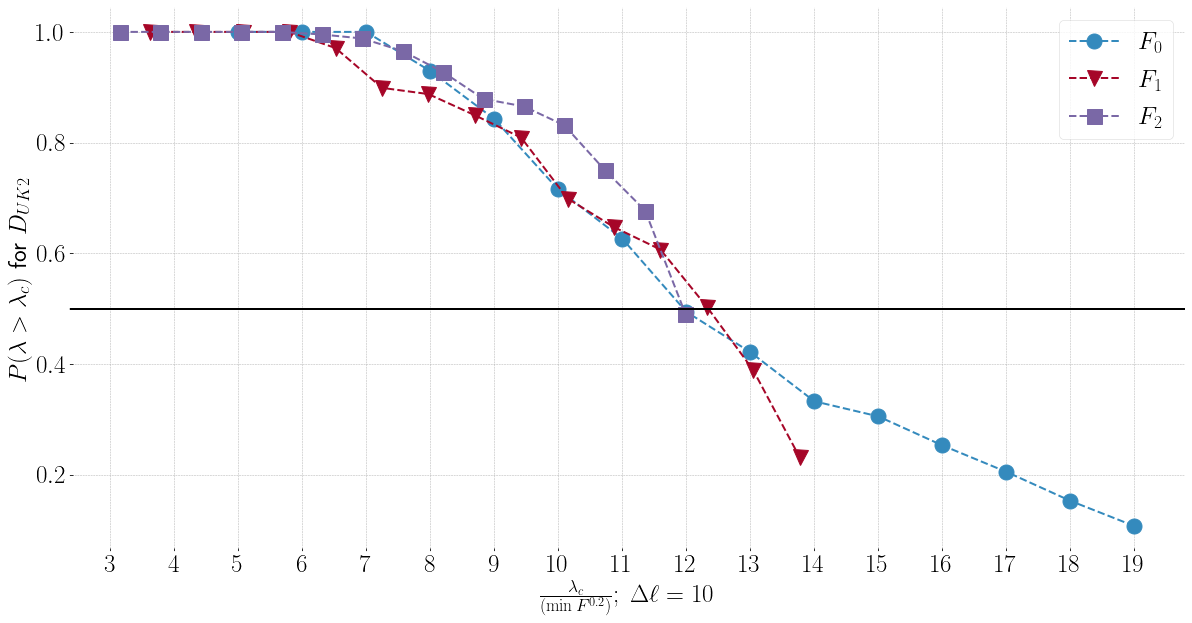

In [39]:
plt.xticks(range(20))
plt.xlabel(r"$\frac{\lambda_{c}}{(\min{F}^{0.2})}; \; \Delta \ell = 10$")
plt.ylabel(r"$P(\lambda > \lambda_c)$ for $D_{UK2}$")
for phi in lcdist.keys():
    plt.plot(lcdist[phi]['uk2'].index / [1, 5**(0.2), 10**(0.2)][phi], lcdist[phi]['uk2'][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
plt.axhline(0.5, color="black")
plt.legend()

## Comparing the results above

I can compare the results in terms of the overall data for all three cohorts. I.e. Using a series that represents all values of $F$. 

In [40]:
fdist3 = {}
lcdist2 = {}
for c in dff.keys():
    %time fdist3[c] = pc.f_histell(dff[c], 1, [10000], uptoapoint=True)
    lcdist2[c] = {}
    df = fdist3[c][0]
    df['p'] = df[0] / sum(df[0])
    for lc in range(5, 20):
        df2 = df.loc[df.index >= lc]
        lcdist2[c][lc] = sum(df2['p'])
    lcdist2[c] = pd.DataFrame.from_dict(lcdist2[c], orient='index')
    lcdist2[c].sort_index(inplace=True)

CPU times: user 2.25 s, sys: 106 ms, total: 2.35 s
Wall time: 2.07 s
CPU times: user 798 ms, sys: 6.47 ms, total: 805 ms
Wall time: 803 ms
CPU times: user 494 ms, sys: 0 ns, total: 494 ms
Wall time: 493 ms


In [41]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdist2.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda_{c}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    for phi in lcdist.keys():
        plt.plot(lcdist[phi][c].index, lcdist[phi][c][0], marker=markers[phi], markersize=15, linestyle="--", label=fr"$F_{phi}$")
    plt.plot(lcdist2[c].index, lcdist2[c][0], marker="X", markersize=15, color="black", linestyle="--", label=r"All $F$")
    plt.legend()
    p += 1

## Without social core group of size 3

Since alters are limited to have $0 \leq \ell \leq 200$; instead of defining the social core group as the three alters with longest lifetimes, I will use the three alters with the highest activity.

In [42]:
cores = {}
for c in pairs.keys():
    cores[c] = {}
    pairs[c] = pc.pairs(calls[c])
    for ego in pairs[c]['ego'].unique():
        thelist = list(pairs[c].loc[pairs[c]['ego'] == ego].sort_values(by='nij', ascending=True)['alter'])
        cores[c][ego] = thelist[-3:]

In [43]:
callsoc = {}
callsnc = {}
for c in calls.keys():
    callsoc[c] = pd.DataFrame()
    callsnc[c] = pd.DataFrame()
    df = calls[c]
    for ego in df['ego'].unique():
        df2 = df.loc[df['ego'] == ego]
        tmp = df2['alter'].isin(cores[c][ego])
        df3 = df2.loc[tmp]
        callsoc[c] = callsoc[c].append(df3).reset_index(drop=True)
        tmp = ~df2['alter'].isin(cores[c][ego])
        df4 = df2.loc[tmp]
        callsnc[c] = callsnc[c].append(df4).reset_index(drop=True)

In [44]:
for c in calls.keys():
    if len(callsnc[c]) + len(callsoc[c]) == len(calls[c]):
        print('success')
    else:
        print(f'review {c}')

success
success
success


In [45]:
dffoc = {}
dffnc = {}
for c in calls.keys():
    %time dffoc[c] = pc.get_f(callsoc[c], 'all', 70, 10)
    %time dffnc[c] = pc.get_f(callsnc[c], 'all', 70, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 861 ms, sys: 0 ns, total: 861 ms
Wall time: 860 ms
CPU times: user 8.16 s, sys: 4.98 ms, total: 8.16 s
Wall time: 8.16 s
CPU times: user 152 ms, sys: 45 µs, total: 152 ms
Wall time: 151 ms
CPU times: user 3.7 s, sys: 19.5 ms, total: 3.72 s
Wall time: 3.72 s
CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 147 ms
CPU times: user 2.25 s, sys: 0 ns, total: 2.25 s
Wall time: 2.24 s


In [46]:
for c in calls.keys():
    if list(dffoc[c].keys()) == list(dffnc[c].keys()):
        print('success')
    else:
        print(f'review {c}')

review mit
success
success


In [47]:
lcdistoc = {}
lcdistnc = {}
for c in dffoc.keys():
    fdistoc = pc.f_histell(dffoc[c], 1, [10000], uptoapoint=True)
    fdistnc = pc.f_histell(dffnc[c], 1, [10000], uptoapoint=True)
    lcdistoc[c] = {}
    lcdistnc[c] = {}
    dfoc = fdistoc[0]
    dfnc = fdistnc[0]
    dfoc['p'] = dfoc[0] / sum(dfoc[0])
    dfnc['p'] = dfnc[0] / sum(dfnc[0])
    for lc in range(5, 20):
        dfoc2 = dfoc.loc[dfoc.index >= lc]
        dfnc2 = dfnc.loc[dfnc.index >= lc]
        lcdistoc[c][lc] = sum(dfoc2['p'])
        lcdistnc[c][lc] = sum(dfnc2['p'])
    lcdistoc[c] = pd.DataFrame.from_dict(lcdistoc[c], orient='index')
    lcdistoc[c].sort_index(inplace=True)
    lcdistnc[c] = pd.DataFrame.from_dict(lcdistnc[c], orient='index')
    lcdistnc[c].sort_index(inplace=True)

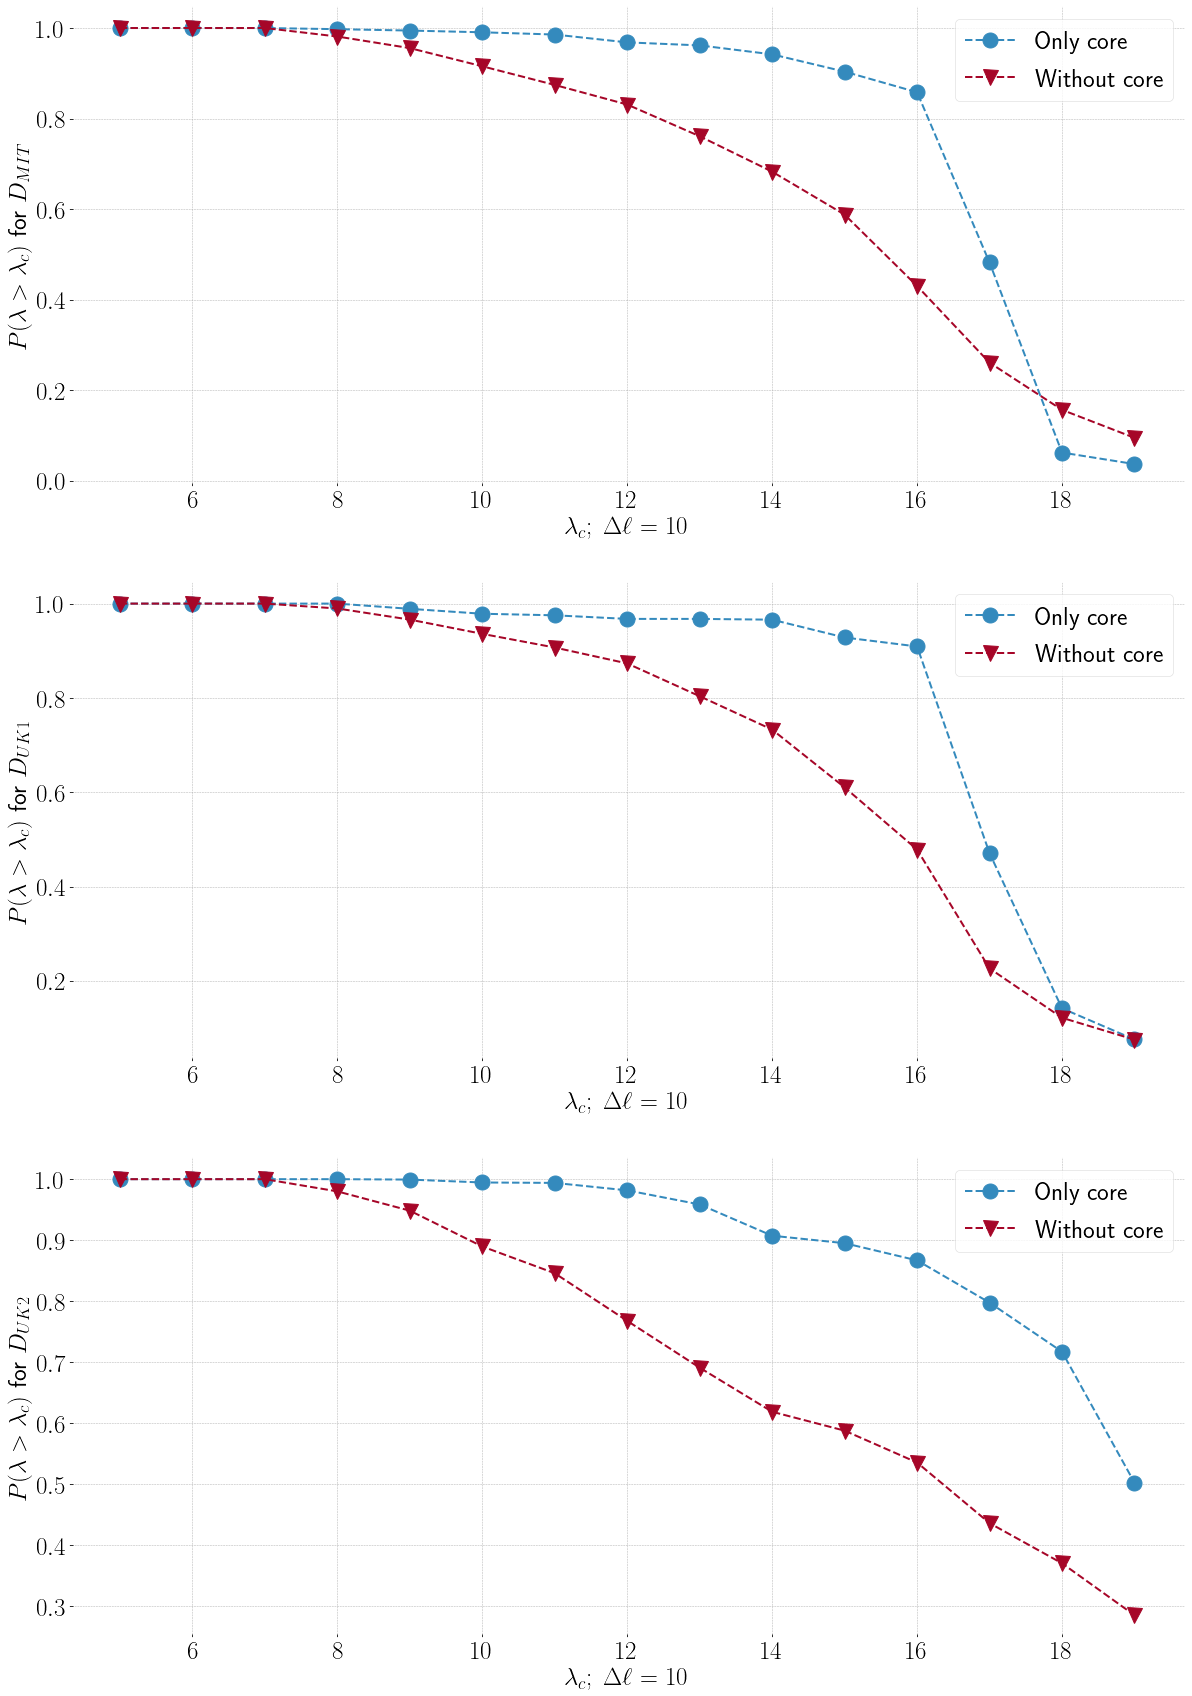

In [48]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdistoc.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"$\lambda_{c}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    plt.plot(lcdistoc[c].index, lcdistoc[c][0], marker=markers[0], markersize=15, linestyle="--", label=r"Only core")
    plt.plot(lcdistnc[c].index, lcdistnc[c][0], marker=markers[1], markersize=15, linestyle="--", label=r"Without core")
    plt.legend()
    p += 1

# Collapsing curves of non-core alters

For this section I will only use the curves for non-core alters and collapse curves of $\phi$, using $\Delta F = 3$. The reason to only use the non-core alters is that the shep of the curve is going to be similar to $F > 10$.

In [49]:
lcdistnc = {}
for c in dffnc.keys():
    fdistnc = pc.f_histell(dffnc[c], 1, [], binned=True, deltaF=3)
    lcdistnc[c] = {}
    for phi in [0, 1, 2, 3]:
        lcdistnc[c][phi] = {}
        dfnc = fdistnc[phi]
        dfnc['p'] = dfnc[0] / sum(dfnc[0])
        for lc in range(5, 20):
            dfnc2 = dfnc.loc[dfnc.index >= lc]
            lcdistnc[c][phi][lc] = sum(dfnc2['p'])
        lcdistnc[c][phi] = pd.DataFrame.from_dict(lcdistnc[c][phi], orient='index')
        lcdistnc[c][phi].sort_index(inplace=True)

In [50]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdistnc.keys():
    plt.subplot(3, 1, p)
    plt.xticks(range(20))
    plt.xlabel(r"$\frac{\lambda_{c}}{(\phi\Delta F + 1)^{0.1}}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    m = 0
    for phi in lcdistnc[c].keys():
        plt.plot(lcdistnc[c][phi].index / ((phi * 3) + 1)**(0.1), lcdistnc[c][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        m += 1
    plt.legend()
    p += 1

Using different scaling

In [51]:
np.log(1 * 3 - 1)

0.6931471805599453

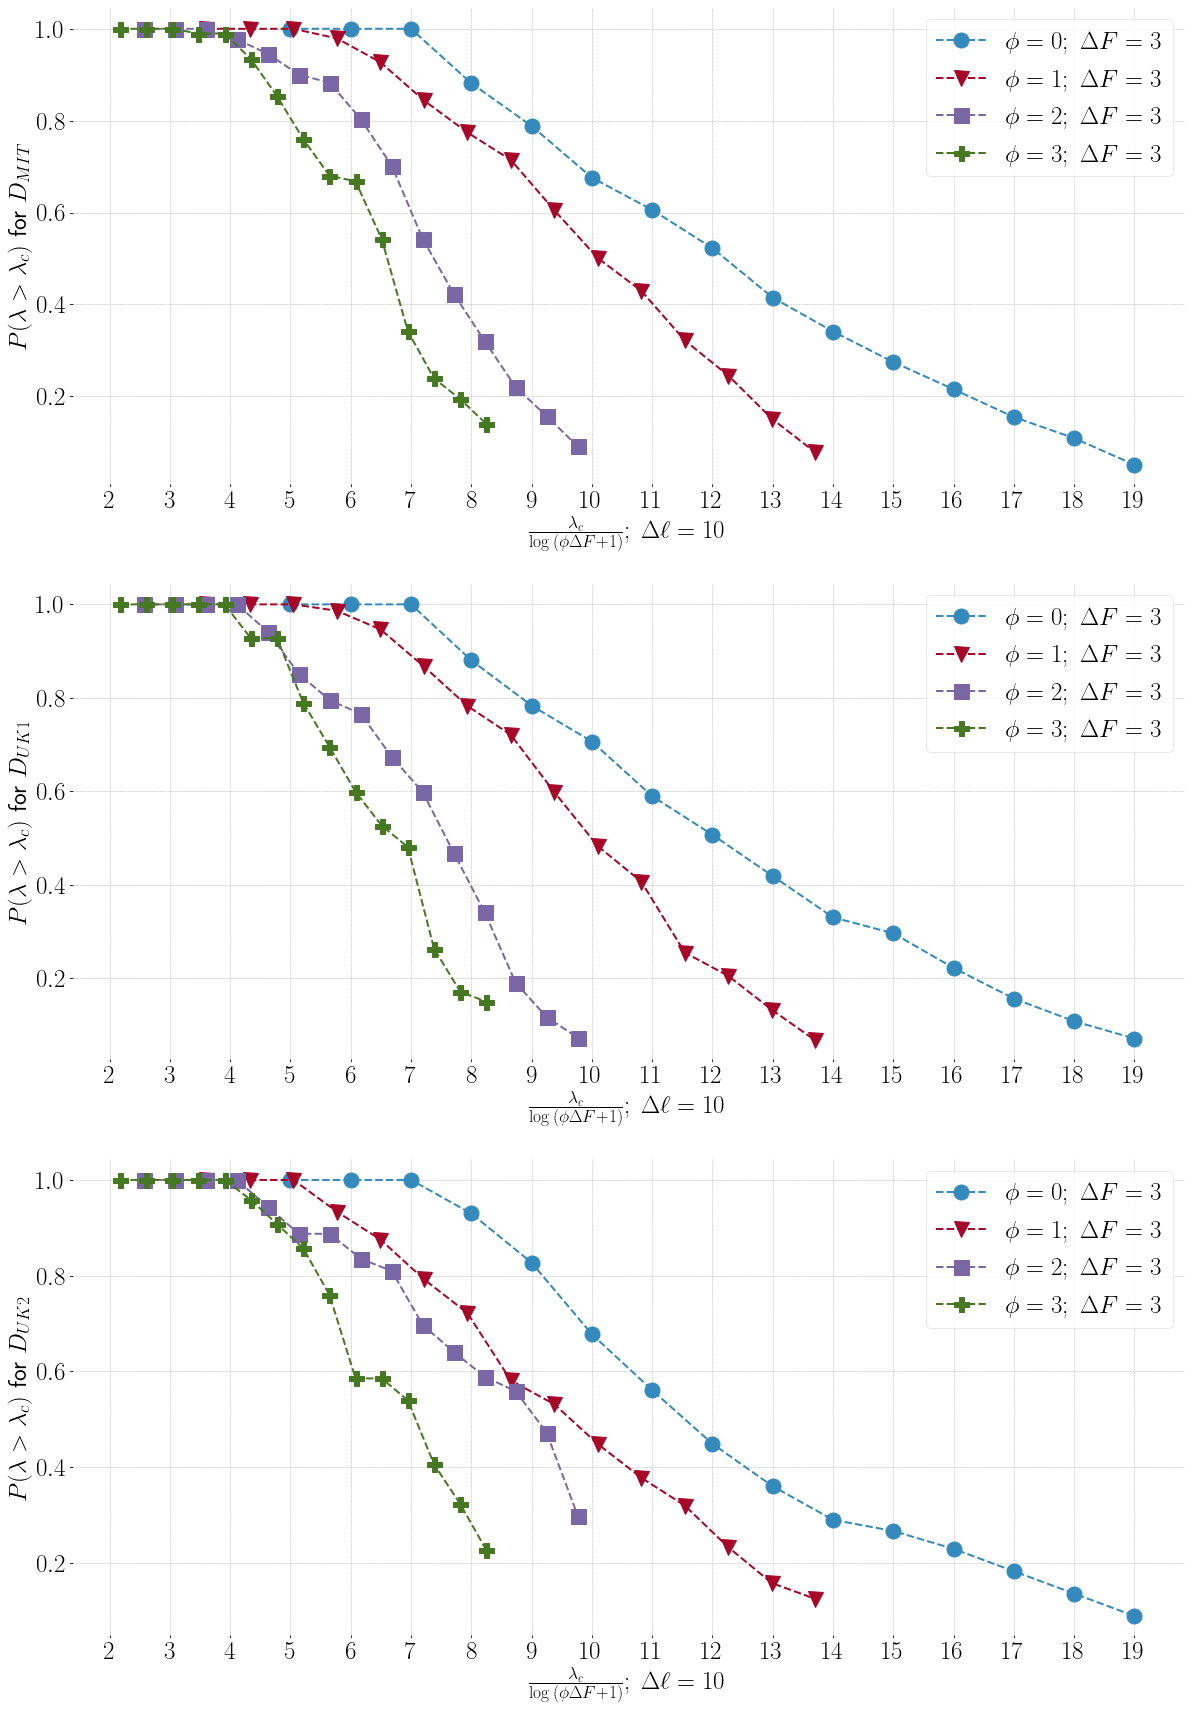

In [63]:
plt.figure(figsize=(20, 30))
p = 1
for c in lcdistnc.keys():
    plt.subplot(3, 1, p)
    plt.xticks(range(20))
    plt.xlabel(r"$\frac{\lambda_{c}}{\log{(\phi\Delta F + 1)}}; \; \Delta \ell = 10$")
    plt.ylabel(fr"$P(\lambda > \lambda_c)$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p - 1]}$")
    m = 0
    for phi in lcdistnc[c].keys():
        if phi > 0:
            plt.plot(lcdistnc[c][phi].index / np.log(phi * 3 + 1), lcdistnc[c][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        else:
            plt.plot(lcdistnc[c][phi].index / 1, lcdistnc[c][phi][0], marker=markers[m], markersize=15, linestyle="--", label=fr"$\phi = {phi}; \; \Delta F = 3$")
        m += 1
    plt.legend()
    p += 1

# Histogram of $F$

In [53]:
HF = {}
for c in dff.keys():
    HF[c] = {}
    for ego in dff[c].keys():
        for alter in dff[c][ego].keys():
            for F in dff[c][ego][alter]['f']:
                theF = F
                HF[c][theF] = HF[c].get(theF, 0) + 1
    HF[c] = pd.DataFrame.from_dict(HF[c], orient='index')
    HF[c].sort_index(inplace=True)

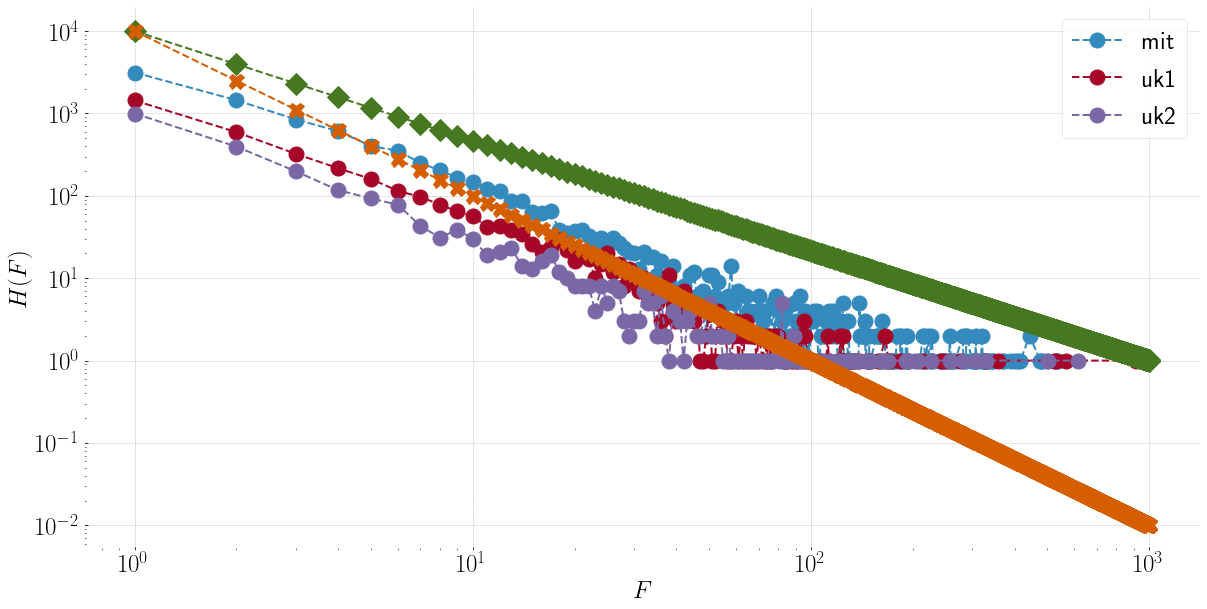

In [54]:
plt.xlabel(r"$F$")
plt.ylabel(r"$H(F)$")
m = 0
plt.yscale("log")
plt.xscale("log")
for c in HF.keys():
    plt.plot(HF[c].index, HF[c][0], marker=markers[m], markersize=15, linestyle="--", label=fr"{c}")
plt.plot(list(range(1, 10**3 + 1)), [(10**4 * i**(-4 / 3)) for i in range(1, 10**3 + 1)], marker="D", markersize=15, linestyle="--")
plt.plot(list(range(1, 10**3 + 1)), [(10**4 * i**(-2)) for i in range(1, 10**3 + 1)], marker="X", markersize=15, linestyle="--")
plt.legend()

In [55]:
HF['mit']

0
1    3143
2    1448
3     844
4     611
5     402
..    ...
480     1
482     1
499     1
531     1
536     1

[221 rows x 1 columns]

# Percentiles of $\lambda$

## Using averages

In [56]:
avg = {}
for c in calls.keys():
    %time dfhatf = pc.hatf(calls[c], lives[c])
    %time avg[c] = pc.get_avg(dfhatf, list(range(0, 100)))

CPU times: user 2.44 s, sys: 3.26 ms, total: 2.45 s
Wall time: 2.44 s
CPU times: user 69.1 ms, sys: 0 ns, total: 69.1 ms
Wall time: 69.1 ms
CPU times: user 870 ms, sys: 0 ns, total: 870 ms
Wall time: 868 ms
CPU times: user 17.8 ms, sys: 21 µs, total: 17.8 ms
Wall time: 16.9 ms
CPU times: user 561 ms, sys: 3.32 ms, total: 564 ms
Wall time: 560 ms
CPU times: user 18.3 ms, sys: 50 µs, total: 18.3 ms
Wall time: 17.4 ms


In [57]:
plt.figure(figsize=(20, 30))
p = 1
fhat = '\hat{F}'
for c in avg.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(r"Percentile of $\lambda$")
    plt.ylabel(fr"${fhat}$ for ${['D_{MIT}', 'D_{UK1}', 'D_{UK2}'][p -1]}$")
    plt.ylim(0, 1)
    x = list(avg[c].keys())
    fx = list(avg[c].values())
    df = []
    dx = []
    for i in range(1, len(x) - 1):
        dx.append((x[i - 1] + x[i + 1]) / 2)
        df.append((fx[i + 1] - fx[i - 1]) / 2 * dx[-1])
    plt.plot(x, fx, marker="o", markersize=12, linestyle="--", label="Average curve")
    plt.plot(dx, df, marker="o", markersize=12, linestyle="--", label="Derivative")
    plt.legend()
    p += 1

## Using splines

## Remove social core group